<a href="https://colab.research.google.com/github/yulbeom/portfolio/blob/main/huggingface_pretrained.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Tokenizer Test

In [ ]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from transformers import AutoTokenizer

checkpoint = 'bert-base-uncased'

tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
inputs = tokenizer("This is the first sentence.", "This is the second one.")
inputs

{'input_ids': [101, 2023, 2003, 1996, 2034, 6251, 1012, 102, 2023, 2003, 1996, 2117, 2028, 1012, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [ ]:
tokenizer.decode(inputs["input_ids"])

'[CLS] this is the first sentence. [SEP] this is the second one. [SEP]'

In [ ]:
tokenizer.convert_ids_to_tokens(inputs["input_ids"])

['[CLS]',
 'this',
 'is',
 'the',
 'first',
 'sentence',
 '.',
 '[SEP]',
 'this',
 'is',
 'the',
 'second',
 'one',
 '.',
 '[SEP]']

## 샘플 2문장으로 감성분석

In [ ]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification

raw_inputs = [
    "I've been waiting for a HuggingFace course my whole life.",
    "I hate this so much!",
]

# 불러올 모델 이름 설정
checkpoint = "bert-base-uncased"
# 1. 불러온 모델의 토크나이저 불러오기
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
inputs = tokenizer(raw_inputs, padding=True, truncation=True, return_tensors="pt")

# 2. 불러온 모델 가져오기
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

# 불러온 모델의 결과
outputs = model(**inputs)

# 해당 문장에 label 설정
inputs["labels"] = torch.tensor([1, 1])

################### 추가
optimizer = AdamW(model.parameters())
loss = model(**inputs).loss
loss.backward() # 자동 미분을 해라
optimizer.step() # 가중치를 업데이트해라
###################

print(outputs.logits)

# 3. postprocessing
predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
model.config.id2label

## mrpc로 감성분석

In [ ]:
!pip install datasets

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 365 kB 26.6 MB/s 
     |████████████████████████████████| 212 kB 59.9 MB/s 
     |████████████████████████████████| 115 kB 50.2 MB/s 
     |████████████████████████████████| 127 kB 8.4 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [ ]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForSequenceClassification
from datasets import load_dataset

In [ ]:
raw_datasets = load_dataset("glue", "mrpc")
raw_datasets

Generating train split:   0%|          | 0/3668 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/408 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1725 [00:00<?, ? examples/s]

Dataset glue downloaded and prepared to /root/.cache/huggingface/datasets/glue/mrpc/1.0.0/dacbe3125aa31d7f70367a07a8a9e72a5a0bfeb5fc42e75c9db75b96da6053ad. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx'],
        num_rows: 1725
    })
})

In [ ]:
raw_train_dataset = raw_datasets['train']
raw_train_dataset[45] # train의 첫 번째 문장

{'sentence1': 'The songs are on offer for 99 cents each , or $ 9.99 for an album .',
 'sentence2': 'The company will offer songs for 99 cents and albums for $ 9.95 .',
 'label': 1,
 'idx': 51}

In [ ]:
raw_train_dataset.features

{'sentence1': Value(dtype='string', id=None),
 'sentence2': Value(dtype='string', id=None),
 'label': ClassLabel(num_classes=2, names=['not_equivalent', 'equivalent'], id=None),
 'idx': Value(dtype='int32', id=None)}

In [ ]:
 # 1. 토크나이저를 불러온다.
 
checkpoint = "bert-base-uncased" # 모델명
tokenizer = AutoTokenizer.from_pretrained(checkpoint)

In [ ]:
tokenizer_sentence_1 = tokenizer(raw_datasets["train"]["sentence1"])
tokenizer_sentence_2 = tokenizer(raw_datasets["train"]["sentence2"])

In [ ]:
tokenized_dataset = tokenizer(
    raw_datasets["train"]["sentence1"],
    raw_datasets["train"]["sentence2"],
    padding=True,
    truncation=True,
) # tokenizer하는 동안 전체 데이터set을 저장할 수 있는 RAM 충분한 경우에만 작동

In [ ]:
def tokenize_function(example):
  return tokenizer(example["sentence1"], example["sentence2"], truncation=True)

In [ ]:
tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
tokenized_datasets # map을 쓰면 토큰화 속도가 빨라진다. 

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

DatasetDict({
    train: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 3668
    })
    validation: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 408
    })
    test: Dataset({
        features: ['sentence1', 'sentence2', 'label', 'idx', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 1725
    })
})

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer) # 패딩 처리

In [ ]:
samples = tokenized_datasets["train"][:8]
samples_a = {k:v for k, v in samples.items() if k not in ["idx", "sentence1", "sentence2"]}
[len(x) for x in samples_a["input_ids"]]

[50, 59, 47, 67, 59, 50, 62, 32]

In [ ]:
batch = data_collator(samples)
{k: v.shape for k, v in batch.items()}
# attention mask
# input_ids
# token_type_ids
# label

ValueError: ignored

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, DataCollatorWithPadding

raw_datasets = load_dataset("glue", "mrpc")
checkpoint = "bert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)


def tokenize_function(example):
    return tokenizer(example["sentence1"], example["sentence2"], truncation=True)


tokenized_datasets = raw_datasets.map(tokenize_function, batched=True)
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

In [ ]:
from transformers import TrainingArguments

training_args = TrainingArguments("test-trainer")

In [ ]:
# 2. 모델 설정하기
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

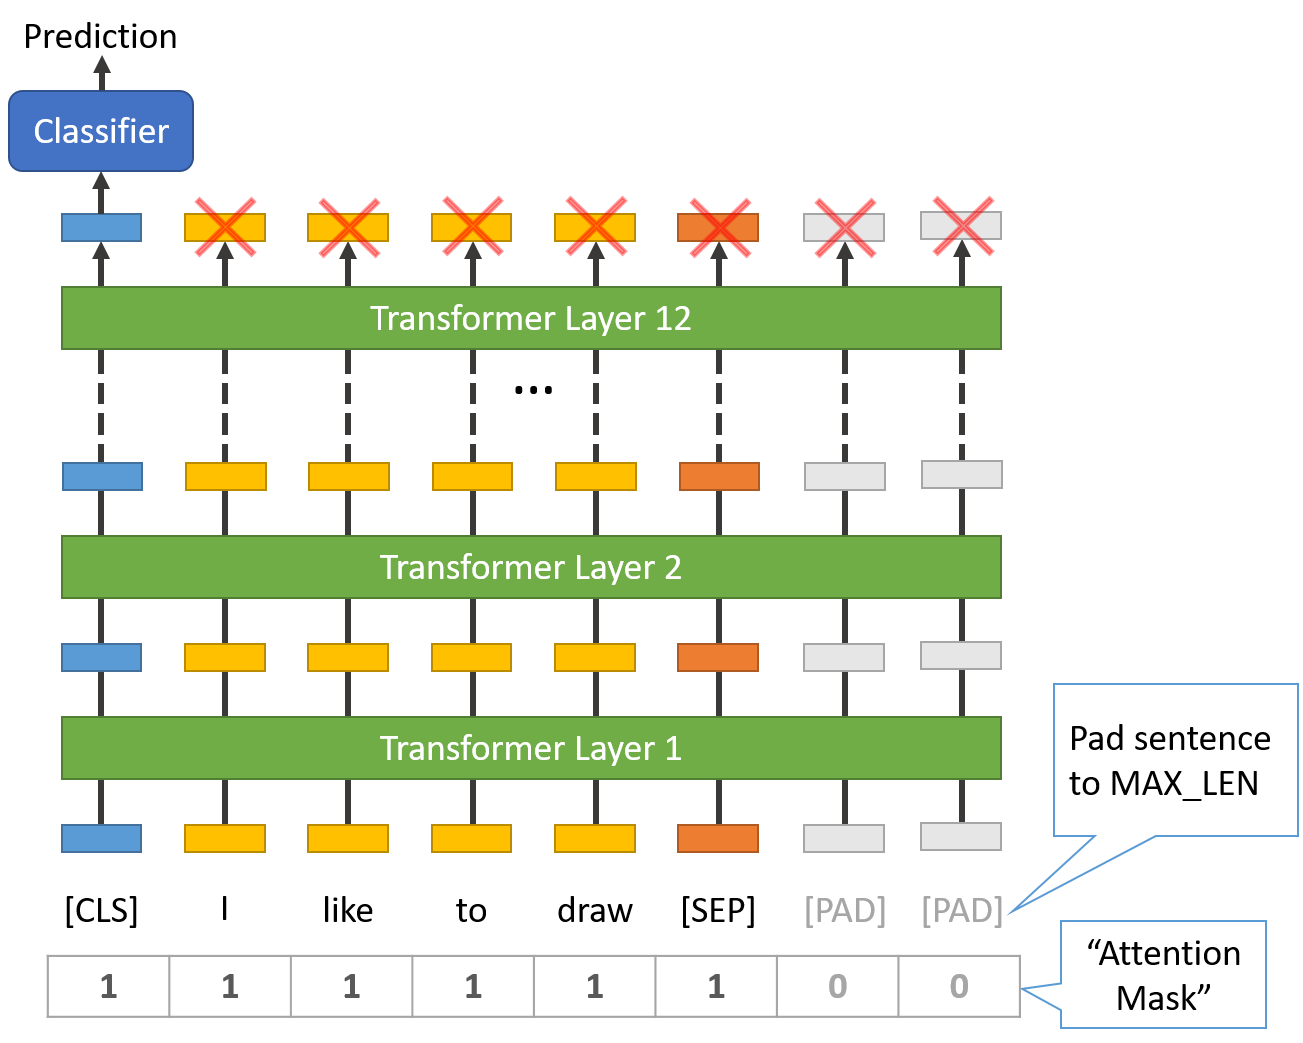

In [ ]:
from transformers import Trainer

trainer = Trainer(
    model, 
    training_args,
    train_dataset = tokenized_datasets["train"],
    eval_dataset = tokenized_datasets["validation"],
    data_collator = data_collator,
    tokenizer = tokenizer,
)

In [ ]:
trainer.train()

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 3668
  Num Epochs = 3
  Instantaneous batch size per device = 8
  Total train batch size (w. parallel, distributed & accumulation) = 8
  Gradient Accumulation steps = 1
  Total optimization steps = 1377
The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx. If sentence2, sentence1, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


Step,Training Loss
500,0.585500
1000,0.407700


Saving model checkpoint to test-trainer/checkpoint-500
Configuration saved in test-trainer/checkpoint-500/config.json
Model weights saved in test-trainer/checkpoint-500/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-500/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-500/special_tokens_map.json
Saving model checkpoint to test-trainer/checkpoint-1000
Configuration saved in test-trainer/checkpoint-1000/config.json
Model weights saved in test-trainer/checkpoint-1000/pytorch_model.bin
tokenizer config file saved in test-trainer/checkpoint-1000/tokenizer_config.json
Special tokens file saved in test-trainer/checkpoint-1000/special_tokens_map.json


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=1377, training_loss=0.4401854526849441, metrics={'train_runtime': 206.1401, 'train_samples_per_second': 53.381, 'train_steps_per_second': 6.68, 'total_flos': 406183858377360.0, 'train_loss': 0.4401854526849441, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(tokenized_datasets["validation"])
print(predictions.predictions.shape, predictions.label_ids.shape)

***** Running Prediction *****
  Num examples = 408
  Batch size = 8
The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: sentence2, sentence1, idx. If sentence2, sentence1, idx are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.


(408, 2) (408,)


In [ ]:
import numpy as np

preds = np.argmax(predictions.predictions, axis=-1)

In [ ]:
pip install evaluate

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 69 kB 6.2 MB/s 


In [ ]:
import evaluate

metric = evaluate.load("glue", "mrpc")
metric.compute(predictions=preds, references=predictions.label_ids)

{'accuracy': 0.8431372549019608, 'f1': 0.891156462585034}

In [ ]:
def compute_metrics(eval_preds):
  metric = evaluate.load("glue", "mrpc")
  logits, labels = eval_preds
  predictions = np.argmax(logits, axis=-1)
  return metric.compute(predictions = predictions, references = labels)

In [ ]:
training_args = TrainingArguments("test-trainer", evaluation_strategy="epoch")
model = AutoModelForSequenceClassification.from_pretrained(checkpoint, num_labels=2)

trainer = Trainer(
    model,
    training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics,
)

PyTorch: setting up devices
The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
loading configuration file https://huggingface.co/bert-base-uncased/resolve/main/config.json from cache at /root/.cache/huggingface/transformers/3c61d016573b14f7f008c02c4e51a366c67ab274726fe2910691e2a761acf43e.37395cee442ab11005bcd270f3c34464dc1704b715b5d7d52b1a461abe3b9e4e
Model config BertConfig {
  "_name_or_path": "bert-base-uncased",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": 